In [1]:
from pandas import read_excel
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb
import sys

In [2]:
df = read_excel("https://data.hossam.kr/E06/air_passengers.xlsx")
df

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


#### #02. 데이터의 정상성 확인
그래프 초기화

In [3]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (15, 5)
plt.rcParams["axes.unicode_minus"] = False

데이터 시각화
###### 데이터의 패턴은 보이지만 비정상성임을 알 수 있다.

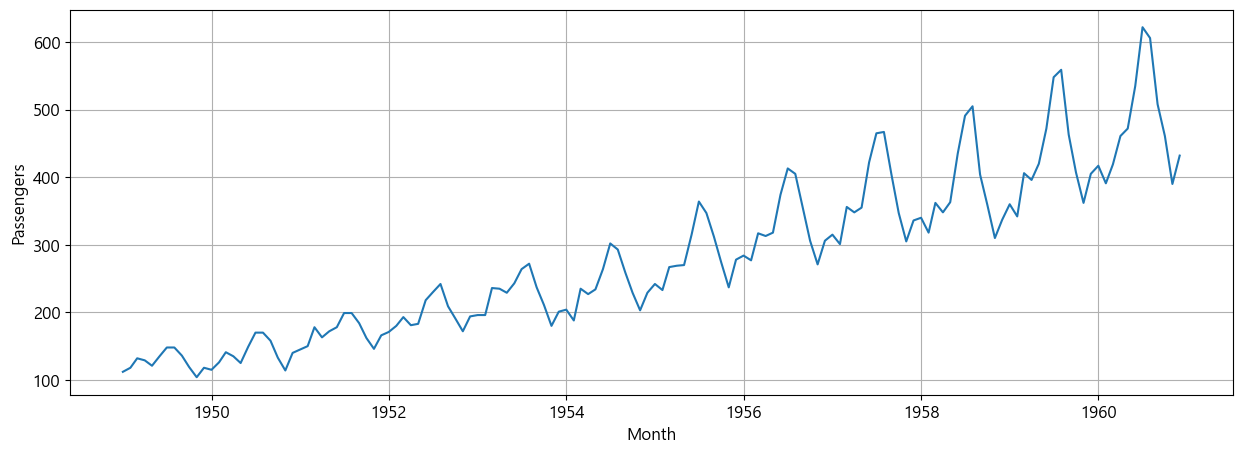

In [4]:
plt.figure()
sb.lineplot(data=df, y='Passengers', x='Month')
plt.grid()
plt.show()
plt.close()

##### 원본 데이터에 대한 ADF 테스트
ADF 테스트의 가설
|가설|내용|
|--|--|
|귀무가설|데이터가 정상성과 다르다(=비정상성임을 의미)|
|대립가설|데이터가 정상성이다.|

In [5]:
ar = adfuller(df['Passengers'])

print('ADF Statistic: %f' % ar[0])
print('p-value: %f' % ar[1])
print('num of lags: %f' % ar[2])
print('num of observations: %f' % ar[3])
print('Critical Values:')
for key, value in ar[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.815369
p-value: 0.991880
num of lags: 13.000000
num of observations: 130.000000
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


1차 차분 수행 
###### 날짜 데이터는 평균을 낼 수 없기 때문에 실 데이터만으로 차분을 수행해야 한다.

In [6]:
diff = df['Passengers'].diff().dropna()
diff

1       6.0
2      14.0
3      -3.0
4      -8.0
5      14.0
       ... 
139   -16.0
140   -98.0
141   -47.0
142   -71.0
143    42.0
Name: Passengers, Length: 143, dtype: float64

차분 결과 시각화
###### 평균은 0으로 일정해 지는 것으로 보이나 뒤로 갈 수록 점점 간격이 커지는 것으로 보아 아직 분산은 일정하지 않은 것으로 여겨짐
###### 즉, 아직은 정상성을 갖는다고 보기 어렵다.

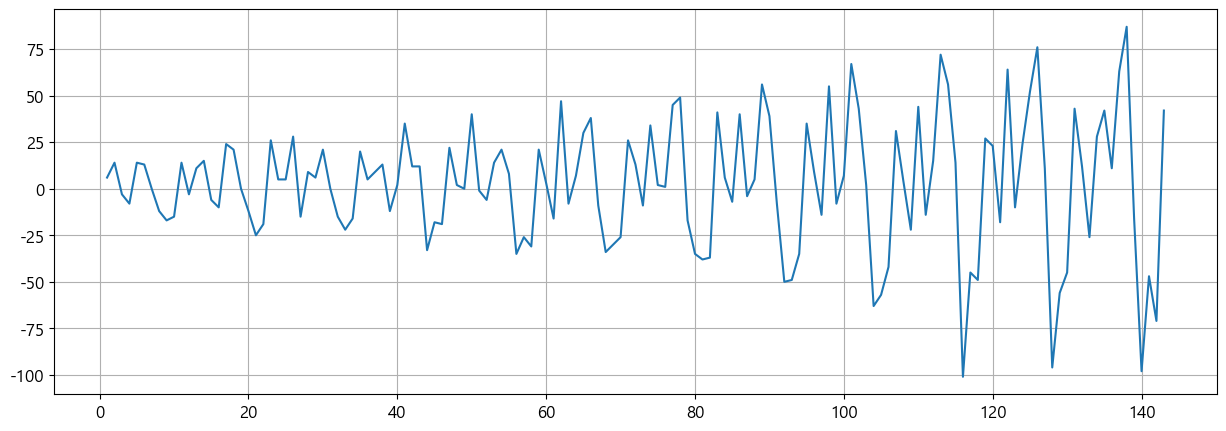

In [7]:
plt.figure()
sb.lineplot(x=diff.index, y=diff.values)
plt.grid()
plt.show()
plt.close()

##### 차분 결과에 대한 ADF 테스트
###### P-value가 아직은 0.05보다 크므로 정상성을 만족하지 않지만 1회 정도 추가로 차분을 수행하면 정상성 데이터 변환이 가능할 것으로 예상됨(여기서는 생략)

In [8]:
ar = adfuller(diff.values)

print('ADF Statistic: %f' % ar[0])
print('p-value: %f' % ar[1])
print('num of lags: %f' % ar[2])
print('num of observations: %f' % ar[3])
print('Critical Values:')
for key, value in ar[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.829267
p-value: 0.054213
num of lags: 12.000000
num of observations: 130.000000
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


#### #03. ACF, PACF 검정
###### 정상 시계열 데이터의 경우, ACF는 상대적으로 빠르게 0(상관관계 0)에 접근한다.
###### 비정상 시계열 데이터의 경우 ACF는 천천히 감소하며 종종 큰 양의 값을 갖는다.

|구분|AR($p$) 모델적합|MA($q$) 모델적합|
|--|--|--|
|ACF plot|천천히 감소|첫 값으로부터 q개 뒤에 끊긴다.|
|PACF plot|첫 값으로부터 p개 뒤에 끊긴다.|천천히 감소|

ACF Plot

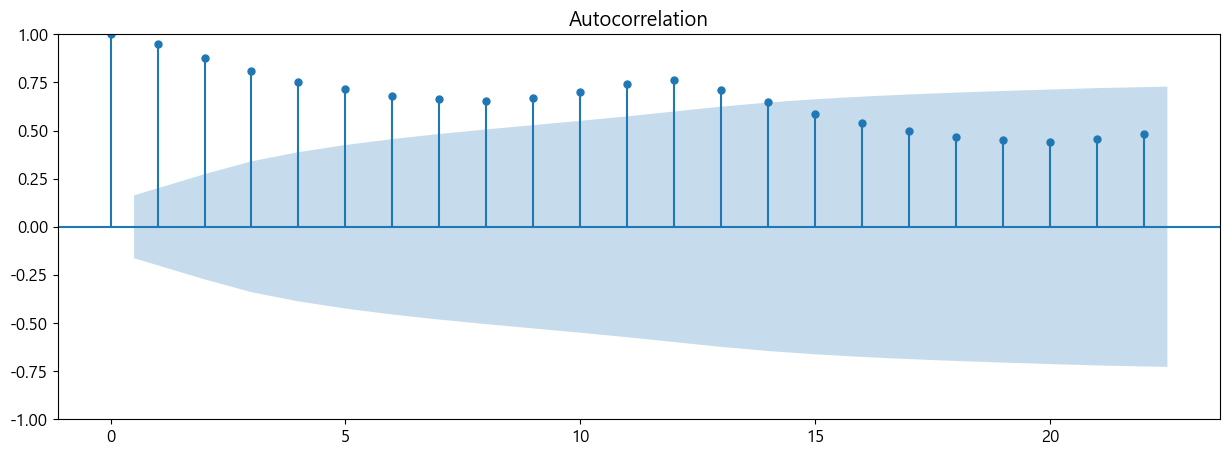

In [9]:
plot_acf(df['Passengers'])
plt.show()
plt.close()

PACF Plot

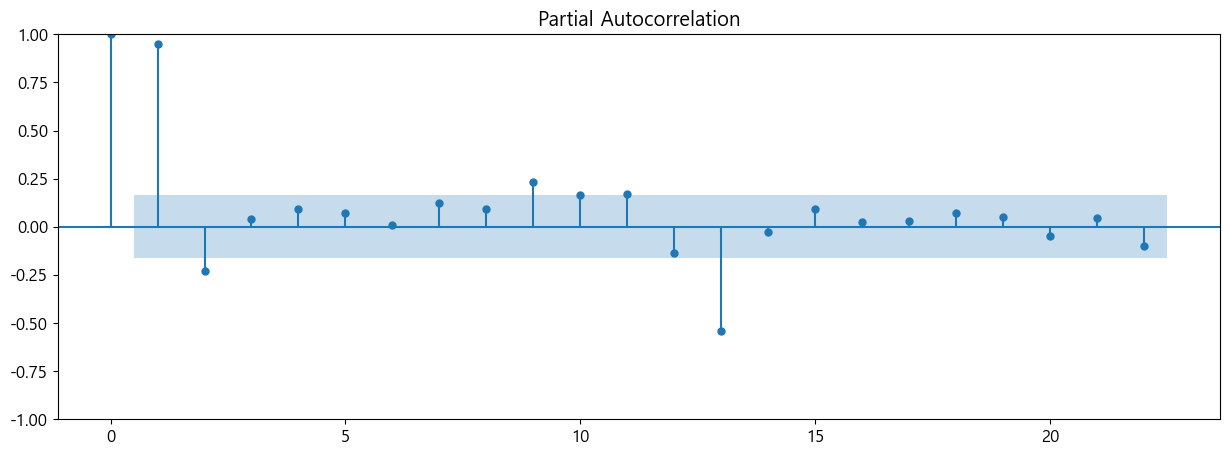

In [10]:
plot_pacf(df['Passengers'])
plt.show()
plt.close()

결과 판정
|구분|ACF plot|PACF plot|
|--|--|--|
|감소|상대적으로 완만|상대적으로 급격|
|파란박스 진입 지점|p=1|q=1|

###### 이 결과를 고려하여 완만함을 보이는 ACF플롯을 채택
###### AR(1) 모델로 결정
###### p-value가 0.05보다 작으므로 귀무가설을 기각하여도 대립가설 채택, 즉, 예제 데이터는 정상성 데이터
###### 만약 귀무가설이 채택되어 정상성이 아니라고 판단될 경우 차분을 1회 수행하고 다시 ADF 검정을 수행
###### 대립가설이 채택될 때 까지 이 과정을 반복함
###### 반복횟수가 d값이 됨
> ###### 이 예제에서는 1번의 차분은 수행해야 한다고 가정함

#### #03. ARIMA 분석 수행

In [11]:
model = ARIMA(df['Passengers'], order=(1,1,0))
fit = model.fit()
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -698.926
Date:                Thu, 03 Aug 2023   AIC                           1401.852
Time:                        11:58:30   BIC                           1407.778
Sample:                             0   HQIC                          1404.260
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3066      0.080      3.849      0.000       0.150       0.463
sigma2      1029.2429    103.738      9.922      0.000     825.920    1232.566
Ljung-Box (L1) (Q):                   0.66   Jarque-

학습 결과에 대한 예측값 생성

In [12]:
start_index = 0
end_index = len(df['Passengers'])
pd = fit.predict(start=start_index, end=end_index)
pd

0        0.000000
1      112.038959
2      119.839303
3      136.291707
4      128.080349
          ...    
140    601.095192
141    477.958052
142    446.592127
143    368.234915
144    444.875121
Name: predicted_mean, Length: 145, dtype: float64

이후 10 단계의 예측값 생성

In [13]:
fc = fit.forecast(10)
fc

144    444.875121
145    448.821995
146    450.031912
147    450.402812
148    450.516512
149    450.551367
150    450.562051
151    450.565327
152    450.566331
153    450.566639
Name: predicted_mean, dtype: float64

관측치와 예측치의 비교 결과 시각화

In [14]:
x = list(range(0, len(df), 20))
x

[0, 20, 40, 60, 80, 100, 120, 140]

In [15]:
xlabels = []

for i in x:
    xlabels.append(df.loc[i, 'Month'].strftime('%Y-%m-%d'))

xlabels

['1949-01-01',
 '1950-09-01',
 '1952-05-01',
 '1954-01-01',
 '1955-09-01',
 '1957-05-01',
 '1959-01-01',
 '1960-09-01']

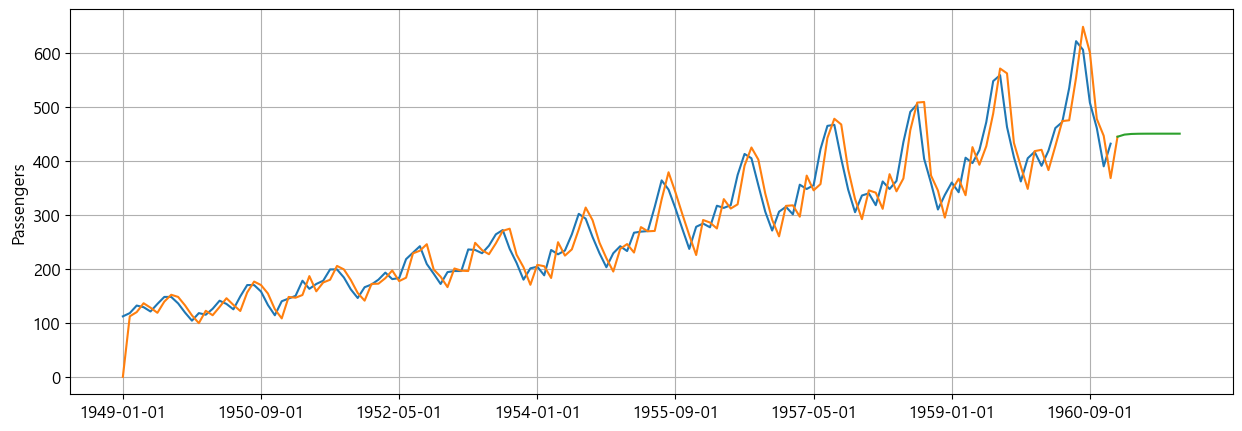

In [16]:
plt.figure()
sb.lineplot(x=df.index, y=df['Passengers']) # 원본
sb.lineplot(x=pd.index, y=pd)           # 원본을 토대로 학습하여 예측한 값
sb.lineplot(x=fc.index, y=fc)           # 이후 10단계를 예측한 값

plt.xticks(x, xlabels, rotation=0)

plt.grid()
plt.show()
plt.close()

#### #05. Auto ARIMA

###### 최적의 ARIMA 모델을 자동으로 찾아서 검색을 수행해주는 기능
##### 원본 데이터에 대한 분석 수행
###### 예제 데이터에서는 파라미터를 변경하여 수행한 결과와 기본값만으로 수행한 결과가 동일하였다.

In [17]:
model = auto_arima(x=df['Passengers'],
                   y=df['Month'], 
                   d=1,                     # 차분 횟수 (default=1)
                   start_p=1,               # default=2
                   max_p=3,                 # default=5 
                   start_q=1,               # default=2
                   max_q=3,                 # default=5
                   seasonal=True,           # 계절성을 고려 여부 (default=True)
                   trace=True,              # 자동으로 ARIMA 모델을 찾는 과정을 출력
                   error_action='ignore',   # 에러가 발생하면 무시
                   suppress_warnings=True   # 경고를 무시
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9529.255, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=76478.633, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9534.927, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10562.511, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.234 seconds


분석 결과 확인

In [18]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4762.628
Date:                Thu, 03 Aug 2023   AIC                           9529.255
Time:                        12:00:54   BIC                           9535.181
Sample:                             0   HQIC                          9531.663
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.629e+15   5.89e+12    446.227      0.000    2.62e+15    2.64e+15
sigma2      4.965e+27      0.069   7.23e+28      0.000    4.97e+27    4.97e+27
Ljung-Box (L1) (Q):                  33.61   Jarque-